#  REALIZAMOS LAS IMPORTACIONES

In [2]:
from datasets import load_dataset

dataset = load_dataset("opus_books", "en-es", split="train[:10%]")

# Mostrar ejemplo
print(dataset[0]["translation"])

{'en': 'Source: Project GutenbergAudiobook available here', 'es': 'Source: Wikisource & librodot.com'}


# CREACIÓN DEL VOCABULARIO

In [27]:
from collections import Counter

def tokenize(text):
    return text.lower().strip().split()

def build_vocab(dataset, field, tokenizer, min_freq=1):
    counter = Counter()
    for example in dataset:
        tokens = tokenizer(example["translation"][field])
        counter.update(tokens)
    vocab = {"<pad>": 0, "<bos>": 1, "<eos>": 2, "<unk>": 3}
    idx = 4
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = idx
            idx += 1
    return vocab

# idioma origen: inglés ('en'), destino: español ('es')
src_vocab = build_vocab(dataset, "en", tokenize, min_freq=1)
tgt_vocab = build_vocab(dataset, "es", tokenize, min_freq=1)

print(f"Vocab inglés: {len(src_vocab)}, español: {len(tgt_vocab)}")


Vocab inglés: 25942, español: 28311


# CREACIÓN DE LA FUNCIÓN DE COLACION

In [28]:
import torch
from torch.nn.utils.rnn import pad_sequence

def encode(text, vocab, tokenizer):
    tokens = ["<bos>"] + tokenizer(text) + ["<eos>"]
    return torch.tensor([vocab.get(tok, vocab["<unk>"]) for tok in tokens], dtype=torch.long)

def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for item in batch:
        src = encode(item["translation"]["en"], src_vocab, tokenize)
        tgt = encode(item["translation"]["es"], tgt_vocab, tokenize)
        src_batch.append(src)
        tgt_batch.append(tgt)
    src_batch = pad_sequence(src_batch, padding_value=src_vocab["<pad>"])
    tgt_batch = pad_sequence(tgt_batch, padding_value=tgt_vocab["<pad>"])
    return src_batch, tgt_batch


# 5 Carga del dataset

In [29]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


# 6 Transformer Encoder - Decoder

In [32]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=4, num_layers=3):
        super().__init__()
        self.src_embed = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embed = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers, num_layers, dim_feedforward=512)
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.pos_enc(self.src_embed(src)).transpose(0, 1)
        tgt = self.pos_enc(self.tgt_embed(tgt)).transpose(0, 1)
        out = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc_out(out.transpose(0, 1))

def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


# 7 Entrenamiento del modelo

In [33]:
NUM_EPOCHS = 5
train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Transformer(len(src_vocab), len(tgt_vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=tgt_vocab["<pad>"])
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Dividir el dataset
from datasets import load_dataset
full_data = load_dataset("opus_books", "en-es")
train_data = full_data["train"].train_test_split(test_size=0.1, seed=42)
train_loader = DataLoader(train_data["train"], batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(train_data["test"], batch_size=32, shuffle=False, collate_fn=collate_fn)

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0

    for src, tgt in train_loader:
        src = src.to(device).transpose(0, 1)
        tgt = tgt.to(device).transpose(0, 1)
        tgt_input = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
        output = model(src, tgt_input, tgt_mask=tgt_mask)
        loss = criterion(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_train_loss += loss.item()

    train_losses.append(total_train_loss / len(train_loader))

    # Validación
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for src, tgt in val_loader:
            src = src.to(device).transpose(0, 1)
            tgt = tgt.to(device).transpose(0, 1)
            tgt_input = tgt[:, :-1]
            tgt_out = tgt[:, 1:]

            tgt_mask = generate_square_subsequent_mask(tgt_input.size(1)).to(device)
            output = model(src, tgt_input, tgt_mask=tgt_mask)
            val_loss = criterion(output.reshape(-1, output.shape[-1]), tgt_out.reshape(-1))
            total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(val_loader))

    print(f"📘 Época {epoch+1}/{NUM_EPOCHS} | Entrenamiento: {train_losses[-1]:.4f} | Validación: {val_losses[-1]:.4f}")


D:\programacion\proyectos\utec\IA\modulo_3_redes_recurrentes_modelos_basados_em_accion\.venv\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


📘 Época 1/5 | Entrenamiento: 5.0954 | Validación: 4.6037
📘 Época 2/5 | Entrenamiento: 4.4279 | Validación: 4.3110
📘 Época 3/5 | Entrenamiento: 4.1239 | Validación: 4.1146
📘 Época 4/5 | Entrenamiento: 3.8903 | Validación: 3.9869
📘 Época 5/5 | Entrenamiento: 3.7006 | Validación: 3.9015


In [34]:
import pickle

torch.save(model.state_dict(), "transformer_en_es.pth")

with open("src_vocab.pkl", "wb") as f:
    pickle.dump(src_vocab, f)
with open("tgt_vocab.pkl", "wb") as f:
    pickle.dump(tgt_vocab, f)

print("✅ Modelo y vocabularios guardados.")


✅ Modelo y vocabularios guardados.


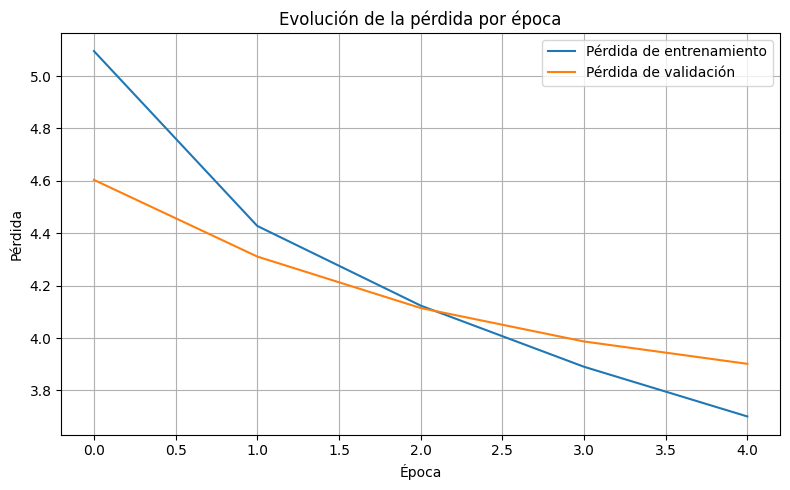

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Pérdida de entrenamiento')
plt.plot(val_losses, label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Evolución de la pérdida por época')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Probamos el entrenamiento

In [36]:
def translate_sentence(model, sentence, src_vocab, tgt_vocab, max_len=40):
    model.eval()
    inv_tgt_vocab = {v: k for k, v in tgt_vocab.items()}

    # Codificar y ajustar dimensión batch
    src_tensor = encode(sentence, src_vocab, tokenize).unsqueeze(0).to(device)  # [1, src_len]
    tgt_tensor = torch.tensor([[tgt_vocab["<bos>"]]], dtype=torch.long).to(device)  # [1, 1]

    for _ in range(max_len):
        tgt_mask = generate_square_subsequent_mask(tgt_tensor.size(1)).to(device)
        out = model(src_tensor, tgt_tensor, tgt_mask=tgt_mask)
        next_token = out.argmax(-1)[:, -1].item()  # último token predicho
        tgt_tensor = torch.cat([tgt_tensor, torch.tensor([[next_token]], device=device)], dim=1)
        if next_token == tgt_vocab["<eos>"]:
            break

    tokens = [inv_tgt_vocab.get(idx, "<unk>") for idx in tgt_tensor.squeeze().tolist()]
    return " ".join(tokens[1:-1])  # quitar <bos> y <eos>


# 🔄 Prueba con tu propia frase
test_sentences = [
    "Where is the train station?",
    "What is your name?",
    "I like reading books.",
    "Do you speak Spanish?",
    "I live in a small house.",
    "The weather is nice today.",
    "She is my sister.",
    "I need help, please.",
    "Can you come with me?",
    "This is a beautiful city."
]
print("🔄 Traducciones del modelo:\n")
for sent in test_sentences:
    translation = translate_sentence(model, sent, src_vocab, tgt_vocab)
    print(f"EN: {sent}")
    print(f"ES: {translation}")
    print("-" * 40)


🔄 Traducciones del modelo:

EN: Where is the train station?
ES: ¿dónde está el <unk> <unk>
----------------------------------------
EN: What is your name?
ES: ¿qué es su <unk>
----------------------------------------
EN: I like reading books.
ES: como <unk> <unk>
----------------------------------------
EN: Do you speak Spanish?
ES: <unk> <unk> <unk> <unk>
----------------------------------------
EN: I live in a small house.
ES: <unk> en un rincón de casa.
----------------------------------------
EN: The weather is nice today.
ES: el tiempo es <unk> <unk>
----------------------------------------
EN: She is my sister.
ES: es mi hermana.
----------------------------------------
EN: I need help, please.
ES: <unk> <unk>
----------------------------------------
EN: Can you come with me?
ES: ¿cómo <unk> <unk>
----------------------------------------
EN: This is a beautiful city.
ES: es una <unk> <unk> <unk>
----------------------------------------
